# Vectorization and arrays: Period-doubling bifurcations, and the Mandelbrot Set

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

In [1]:

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

# Import numpy library for array manipulation
import numpy as np



# External libraries

A major benefit of the Python ecosystem is the ability to easily import external libraries. This is done with the `import` command. For example, the following imports the `numpy` library, which contains many useful functions for scientific computing.

```python
import numpy as np
```

Common libraries you might use in the natural sciences include
+ + matplotlib (plotting)
+ + numpy (linear algebra; lots of MATLAB functions)
+ + scipy (common scientific algorithms)
+ + scikit-learn (machine learning)
+ + networkx (making graphs)

Major libraries you might use in data science include
+ + numba (just-in-time compilation of numpy-based code)
+ + pandas (large dataset organization; lots of R functionality)
+ + statsmodels (statistics; lots of R functionality)
+ + seaborn (plotting; alternative to matplotlib with API similar to R's ggplot)
+ + PyTorch (deep learning)
+ + JAX (deep learning)


Typical usage (in terminal): install 

```bash
    conda activate myenvironment
    conda install pandas
```

When conda fails, or the package is not available, use pip

```bash
    pip install pandas
```

Then either launch launch JupyterLab from terminal, or open VSCode app and select the appropriate environment in the upper-right hand corner


In [97]:
import matplotlib.pyplot as plt # Plotting library
import numpy as np # Linear algebra library
import scipy # General scientific computing library


## Arrays, indexing, broadcasting, vectorization

+ Numpy is technically an external library, but we will use it so often in scientific computing that it's basically a built-in data type for our purposes.

+ Suite of support for the `np.ndarray` datatype, which represents tensors. Most MATLAB functions are within numpy

In [182]:
import numpy as np

a = np.arange(10)

print(a)
type(a)

[0 1 2 3 4 5 6 7 8 9]


numpy.ndarray

In [185]:
a = np.random.random((2, 3))
print(a)

a = np.identity(7)
print(a)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


## The logistic map

The logistic map is a polynomial mapping (equivalently, recurrence relation) of degree 2, often cited as an archetypal example of how complex, chaotic behaviour can arise from very simple non-linear dynamical equations.

The map is defined by:

$$x_{n+1} = r x_n (1 - x_n)$$

where the dynamical variable $x_n \in (0, 1)$ is a number between zero and one. The parameter $r$ represents a growth rate, and varies between zero and four. For $r$ values between zero and one, the population always dies out. However, as $r$ increases past one, a bifurcation occurs at $r=3$, where the population begins to oscillate between two values. As $r$ increases further, period doubling occurs, leading to four values, then eight, and so on, until finally chaos occurs, and the population takes on seemingly random values between zero and one.

Text(0, 0.5, 'x')

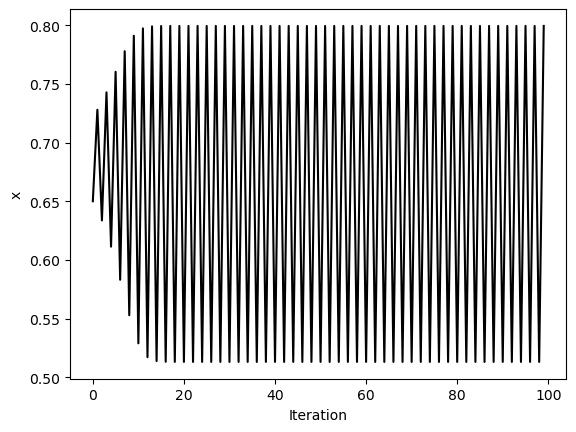

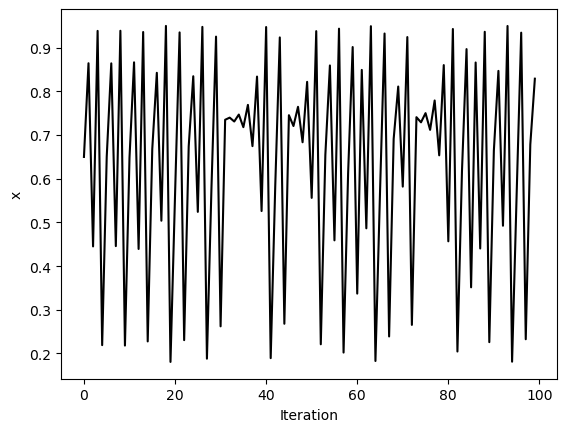

In [200]:
# logistic map
import numpy as np
import matplotlib.pyplot as plt

def logistic_map(x, r=3.7):
    """
    The logistic map, a discrete-time dynamical system.

    Args:
        x (float): a number in [0, 1] denoting the current state
        r (float): a positive parameter that controls the chaoticity of the dynamics
    """
    return r * x * (1 - x)

r = 3.2
x = [0.65]
for i in range(1, 100):
    x.append(logistic_map(x[i-1], r))
plt.figure()
plt.plot(x, 'k')
plt.xlabel('Iteration')
plt.ylabel('x')



r = 3.8
x = [0.65]
for i in range(1, 100):
    x.append(logistic_map(x[i-1], r))
plt.figure()
plt.plot(x, 'k')
plt.xlabel('Iteration')
plt.ylabel('x')


## Runtime complexity and dynamical systems

+ A common question we might ask for an algorithm is: How does the runtime scale with the input size? What about the memory usage?

+ These are sometimes called the asymptotic *time and space complexities* of an algorithm.

+ The asymptotic complexity of an algorithm is *independent* of the hardware and software environment. It is a representationn-invariant mathematical property of the algorithm.

In [194]:
import numpy as np

def simulate_logistic(n, r=3.8, x0=0.65):
    """
    Simulate the logistic map for n iterations using numpy and preallocation

    Args:
        n (int): The number of iterations of the logistic map
    """
    x = np.zeros(n) # Preallocate an array of zeros
    x[0] = x0
    for i in range(1, n):
        prev = x[i - 1]
        x[i] = r * prev * (1 - prev)
    return x

# x = simulate_logistic(1000)
# plt.plot(x, 'k')

%timeit simulate_logistic(1000)

188 µs ± 3.88 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Text(0, 0.5, 'Runtime (s)')

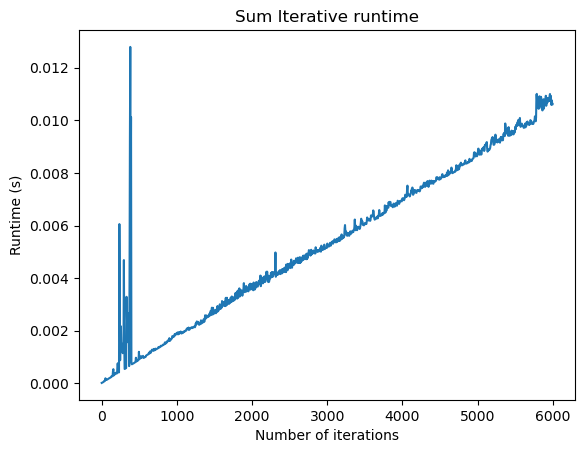

In [17]:
import timeit

n_vals = np.arange(1, 6000, 5)
# n_vals = np.logspace(1, 5, 50, dtype=np.int32)

times = []
for n in n_vals:
    times.append(timeit.timeit("simulate_logistic(n)", globals=globals(), number=10))

plt.figure()
plt.plot(n_vals, times)
plt.title("Sum Iterative runtime")
plt.xlabel("Number of iterations")
plt.ylabel("Runtime (s)")


Notice that in the asymptotic regime the runtime scales linearly.

Why is the runtime $\sim N$? We only "touch" each element of our solution array twice---once to calculate it, and once to update the next state. We don't need to look back at all the previous states.

The memory usage is also $\sim N$ because we are storing the full, cumulative history in order to plot the trajectory. If we only wanted to plot the final state, we could get away with only storing the final state. In this case, the memory would be $\sim 1$.

+ Now that we have a fast implementation of the logistic map, we can explore its properties in more detail.

+ We will create a bifurcation diagram, which shows the values of $x_n$ for each value of $r$.

In [196]:
def bifurcation_diagram(dmap, x0, pvals, n=1000, transient=0.5):
    """
    Create a bifurcation diagram of a discrete map.

    Args:
        dmap (callable): A function that takes two arguments, x and p, and returns the next
            value of x in the discrete map.
        x0 (float): The initial condition of the system.
        pvals (list): A list of parameter values.
        n (int): The number of iterations of the map to run for each parameter value.
        transient (float): The proportion of the initial iterations to discard as transient.

    Returns:
        xvals (list): A list of lists of x values.
    """
    n_discard = int(transient * n)
    all_xvals = []
    for p in pvals:
        vals = simulate_logistic(n, r=p, x0=x0)
        all_xvals.append(vals[n_discard:])

    return all_xvals

Text(0, 0.5, 'x')

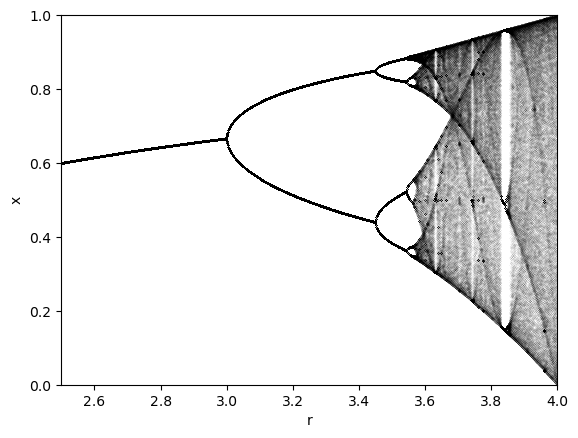

In [197]:

rvals = np.linspace(2.5, 4.0, 1000)
xvals = bifurcation_diagram(logistic_map, 0.65, rvals)

for r, x in zip(rvals, xvals):
    plt.plot([r] * len(x), x, '.k', markersize=0.05)
plt.xlim(rvals[0], rvals[-1])
plt.ylim(0, 1)
plt.xlabel('r')
plt.ylabel('x')






The logistic map follows the celebrated period-doubling route to chaos. As the parameter $r$ increases, the period of the oscillations doubles, until chaos occurs at $r \approx 3.57$.


Notice how the spacing in $r$ between the period-doubling bifurcations decreases as $r$ increases. The geometric rate of decrease in the spacing between bifurcations is a constant value called the Feigenbaum constant.

# Slicing and indexing numpy arrays

+ These are extremely useful syntax for manipulating arrays in Python

### Slicing

+ We will use slicing to create a *return map* of the logistic map. This is a plot of $x_{n+1}$ vs. $x_n$.

Text(0, 0.5, 'Next Iteration')

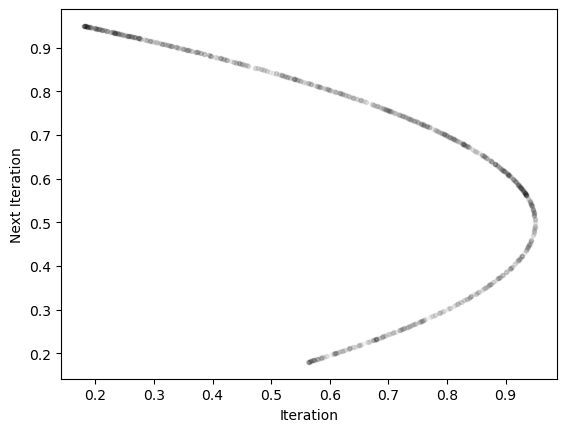

In [201]:
traj = simulate_logistic(1000)

# plt.plot(traj)

plt.figure()
plt.plot(traj[1:], traj[:-1], '.k', alpha=0.05)
plt.xlabel('Iteration')
plt.ylabel('Next Iteration')



Text(0, 0.5, 'Next Next Iteration')

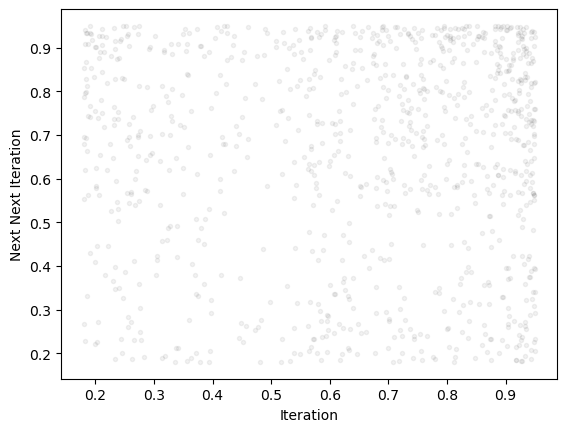

In [204]:
plt.figure()
plt.plot(traj[50:], traj[:-50], '.k', alpha=0.05)
plt.xlabel('Iteration')
plt.ylabel('Next Next Iteration')

### Strided slicing

+ We can use strided slicing to take every $k$th element of an array.

+ To illustrate this effect, let's first simulate the Logistic map for several values of the bifurcation parameter $r$. We will store all of these trajectories


Text(0, 0.5, 'x')

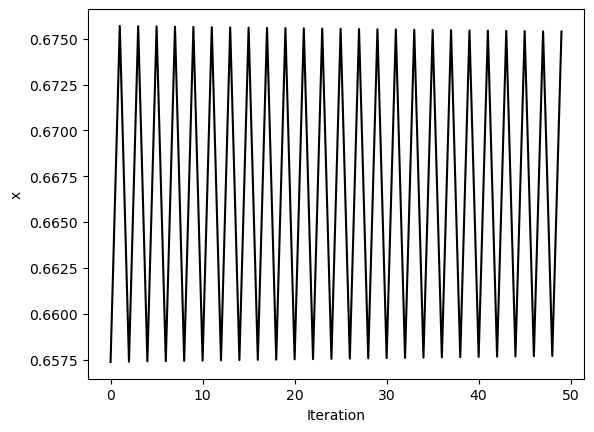

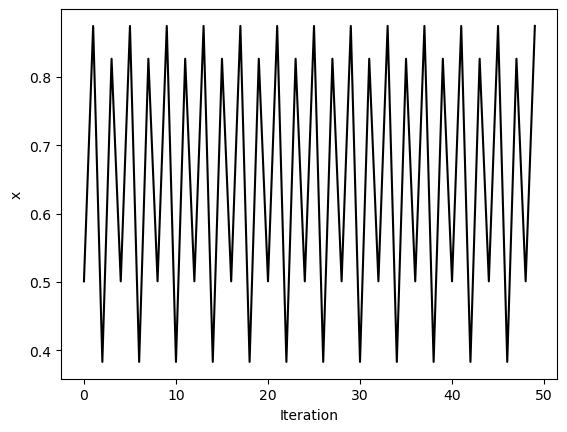

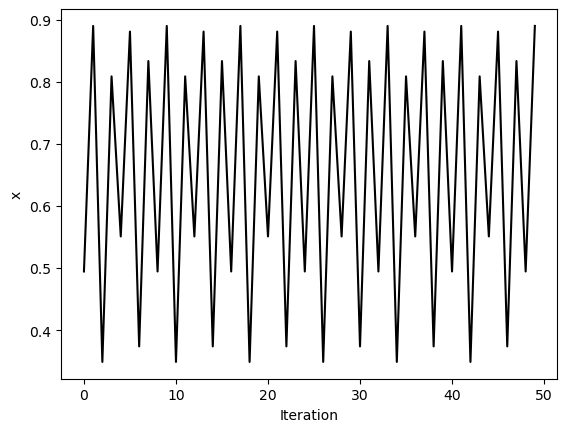

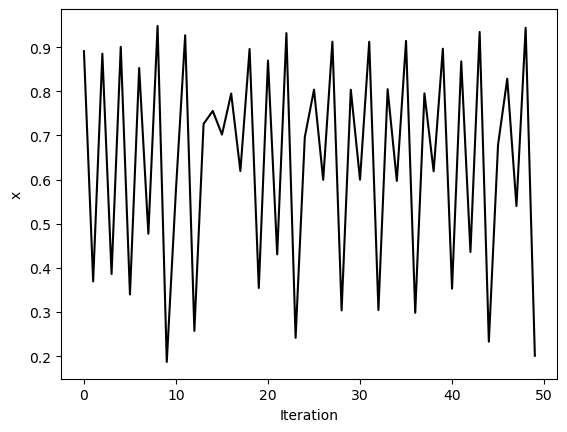

In [205]:
# simulate before and after period doubling
# Take last 50 iterations to remove transient

traj2 = simulate_logistic(500, r=3)[-50:]
plt.figure()
plt.plot(traj2, 'k')
plt.xlabel('Iteration')
plt.ylabel('x')

traj4 = simulate_logistic(500, r=3.5)[-50:]
plt.figure()
plt.plot(traj4, 'k')
plt.xlabel('Iteration')
plt.ylabel('x')

traj8 = simulate_logistic(1000, r=3.56)[-50:]
plt.figure()
plt.plot(traj8, 'k')
plt.xlabel('Iteration')
plt.ylabel('x')

traj_inf = simulate_logistic(500)[-50:]
plt.figure()
plt.plot(traj_inf, 'k')
plt.xlabel('Iteration')
plt.ylabel('x')

+ These trajectories look pretty different, but what happens if we resample them?

+ We will use strided slicing to take every nth element of each array


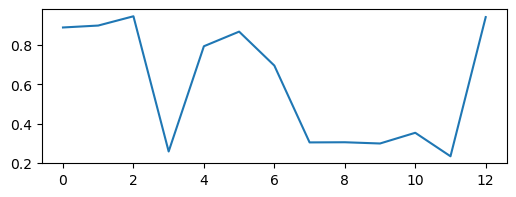

In [220]:
# plt.figure(figsize=(6, 2))
# plt.plot(traj2)

# plt.figure(figsize=(6, 2))
# plt.plot(traj4[::1])

# plt.figure(figsize=(6, 2))
# plt.plot(traj8[::8])

plt.figure(figsize=(6, 2))
plt.plot(traj_inf[::4])

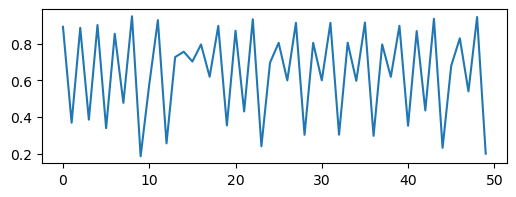

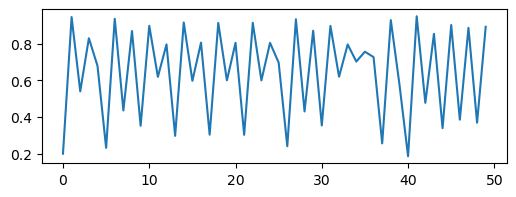

In [225]:
plt.figure(figsize=(6, 2))
plt.plot(traj_inf[::1])

plt.figure(figsize=(6, 2))
plt.plot(traj_inf[::-1])

### Boolean Selection with numpy arrays

+ We can index into Python arrays using a Boolean array of the same shape

+ These will select out elements of the outer array whereever the Boolean array is True

+ The resulting array have a size proportional to the number of True elements in the Boolean array


[[0.03706901 0.3868108  0.80144563 0.11931178 0.62020471]
 [0.29632615 0.47796229 0.70041659 0.85303676 0.83618991]
 [0.17743535 0.3720211  0.74583951 0.61744053 0.90010932]
 [0.39727078 0.21999045 0.53016913 0.94071539 0.91632947]
 [0.95495071 0.30877553 0.7893046  0.76895121 0.2782278 ]]
[[ True  True False  True False]
 [ True  True False False False]
 [ True  True False False False]
 [ True  True False False False]
 [False  True False False  True]]


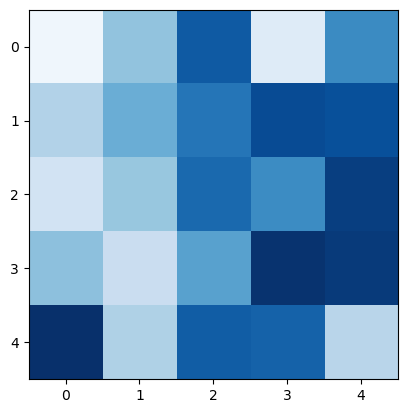

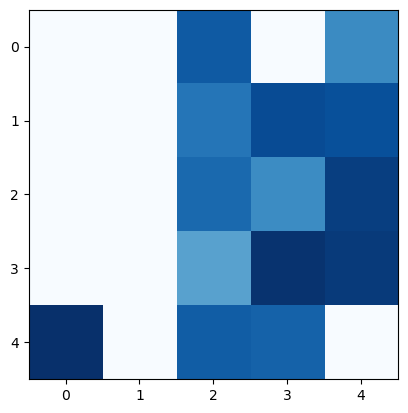

In [230]:
a = np.random.random((5, 5))


plt.figure()
plt.imshow(a, cmap='Blues', vmin=0)

print(a)
# print((a < 0.5))

ind = (a < 0.5)
print(ind)
a[ind] = 0
plt.figure()
plt.imshow(a, cmap='Blues', vmin=0)

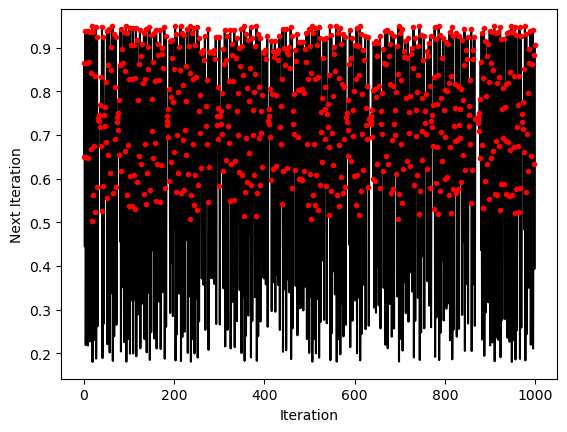

In [139]:
select_inds = traj > 0.5
# print(select_inds)
# nvals = np.arange(len(traj))

nvals = np.arange(len(traj))

plt.figure()
plt.plot(nvals, traj, 'k')
plt.xlabel('Iteration')
plt.ylabel('Next Iteration')
plt.plot(nvals[select_inds], traj[select_inds], '.r')


+ Now, let's use Boolean selection to select the points corresponding to when the logistic map crosses the point $x = 0.5$.

+ We will first threshold the trajectory into a series of 0s and 1s corresponding to whether the trajectory is above or below 0.5.

+ We then use `np.diff`, which calculates the difference between subsequent elements of the logistic map, in order to find places where the map crosses the threshold.


Text(0, 0.5, 'Frequency')

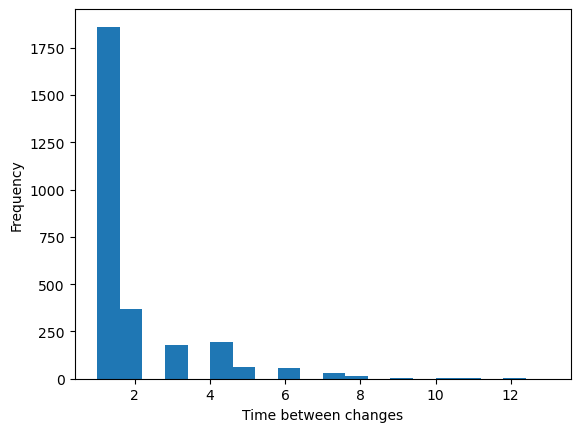

In [141]:
## We want to perform a longer simulation
traj = simulate_logistic(5000)

where_big = (traj > 0.5).astype(int)
where_change = np.diff(where_big)
changepoints = (where_change != 0)
changepoint_inds = np.where(changepoints)[0]

time_between_changes = np.diff(changepoint_inds)

plt.figure()
plt.hist(time_between_changes, bins=20);
plt.xlabel('Time between changes')
plt.ylabel('Frequency')



Interestingly, we observe an exponential waiting time distribution, in which the map occasionally takes a very long amount of time to cross from one side of the threshold to the other.

### Fancy indexing

+ Can pass lists of indices to modify

In [56]:
a = np.array([1, 2, 3, 4, 5, 6, 7])

sel_inds = [0, 2, 4]

a[sel_inds] = 0
print(a)

[0 2 0 4 0 6 7]


### Broadcasting

+ We can slice numpy arrays just like lists, but in multiple dimensions
+ singleton dimensions versus empty dimensions
+ Lifting dimensionality makes linear algebra easier

In [238]:
positions = np.random.random(size=(1000,))

print("Empty dimensions", positions.shape) 
print((positions * positions.T).shape) # Elementwise (Hadamard)

positions = np.random.random(size=(1000, 1))
print("Singleton dimension", positions.shape) # Elementwise (Hadamard)
print((positions * positions.T).shape) # Implicit outer product 

Empty dimensions (1000,)
(1000,)
Singleton dimension (1000, 1)
(1000, 1000)


In [243]:
positions = np.random.random(size=(1000,))
print(positions.shape)

positions = positions[None, :]
print(positions.shape)


(1000,)
(1, 1000)


# Vectorization

+ Does not change runtime scaling, but changes the prefactor
+ Runtime at expense of memory

Let's try finding the pairwise distance matrix between two sets of points in two-dimensions. We will do this in two ways: a naive way, and a vectorized way.

Mathematically, we have a vector $X$ of shape $(N, 2)$. We wish to compute the matrix $D$ of shape $(N, N)$, where $D_{ij} = ||X_i - X_j||_2$.


In [244]:
# Random positions dataset
positions = np.random.random(size=(200, 2))
print(positions.shape)

(200, 2)


In [246]:

# pairwise distance matrix will be 100 x 100
def find_distances_iterative(positions):
    """Find the pairwise distances between a set of points"""
    list_of_distances = list()
    for i in range(positions.shape[0]): # Loop over rows
        row_distances = list()
        for j in range(positions.shape[0]): # Loop over columns
            elementwise_distances = list()
            for k in range(positions.shape[1]): # Loop over dimensions
                elementwise_distances.append((positions[i, k] - positions[j, k])**2)
            total_distance = sum(elementwise_distances)
            row_distances.append(np.sqrt(total_distance))
        list_of_distances.append(row_distances)
    distance_matrix = np.array(list_of_distances)
    return distance_matrix

%timeit find_distances_iterative(positions)
# find_distances_iterative(positions).shape

45.7 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


+ Now, let's modify our approach to use a built-in numpy function, `np.linalg.norm`, which calculates the Euclidean norm of a vector. This function is internally vectorized, allowing it to process all dimensions a vector quickly. 

+ Since we know the shape of our output matrix, we can also preallocate the memory for it using `np.zeros`. This is a good practice to avoid Python having to continually resize a list as we add elements to it.

+ Conceptually, we can think of vectorization as numpy processing all of the dimensions of the array at once, rather than looping over them one at a time.
. 

In [156]:

def find_distances_preallocated(positions):
    """
    Find distance matrix with preallocated memory and built-in elementwise numpy functions
    """
    distances = np.zeros((positions.shape[0], positions.shape[0]))
    for i in range(positions.shape[0]):
        for j in range(positions.shape[0]):
            distance = np.linalg.norm(positions[i, :] - positions[j, :])
            distances[i, j] = distance
    return distances

%timeit find_distances_preallocated(positions)


66 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


+ We can do even better if we take the idea of vectorizing a bit further

+ We think about the distinct "dimensions" present in our problem: the two dimensions of the output array (both have value $200$), which each correspond to the first dimension of the input array, and the dimension corresponding to the second dimension of the input array, which has value $2$. 

+ We therefore expect that we need to perform an expansion first, to lift the dimensionality of our $(200, 200)$ input array to an intermediate with shape $(200, 200, 2)$. We can do this using numpy's broadcasting rules. Since we want to find the difference between each element of the input array with itself, we need to do a broadcast subtraction.

+ We next need to perform a contraction, which pulls the $(200, 200, 2)$ intermediate array back down to a $(200, 200)$ output array. We can do this using numpy's built-in functions, which are optimized for linear algebra operations. Since we are computing the Euclidean norm, we can use `np.linalg.norm` to do this contraction in a single step. Other common contractions might include `np.sum`, `np.mean`

In [255]:
print(positions.shape)
print(positions[:, None, :].shape)
print(positions[None, :, :].shape)
print((positions[:, None, :] - positions[None, :, :]).shape)
print(np.linalg.norm((positions[:, None, :] - positions[None, :, :]), axis=2).shape)

(200, 2)
(200, 1, 2)
(1, 200, 2)
(200, 200, 2)
(200, 200)


In [256]:
# pairwise distance matrix
def find_distances_vectorized(positions):
    """
    Find distance matrix vectorized with broadcasting
    """
    return np.linalg.norm(
        positions[:, None, :] - positions[None, :, :], 
    axis=2)

%timeit find_distances_vectorized(positions)

617 µs ± 5.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [95]:
import timeit

n_vals = np.arange(1, 100, 1)

all_times = []
for n in n_vals:
    time1 = timeit.timeit("find_distances_iterative(np.random.random((n, 2)))", globals=globals(), number=n)
    # time2 = timeit.timeit("find_distances_preallocated(np.random.random((n, 2)))", globals=globals(), number=n)
    time3 = timeit.timeit("find_distances_vectorized(np.random.random((n, 2)))", globals=globals(), number=n)
    all_times.append([time1, time2, time3])
all_times = np.array(all_times)




Text(0, 0.5, 'Runtime (s)')

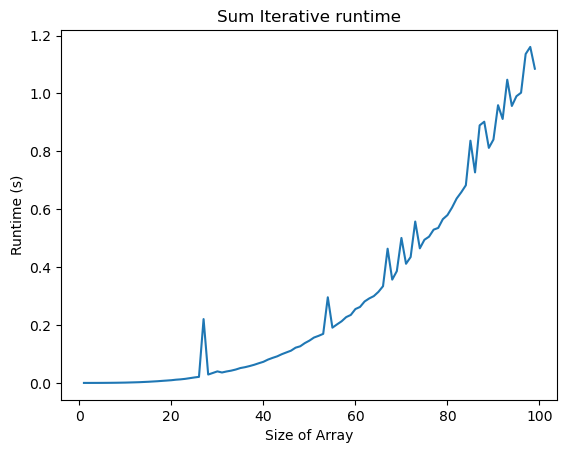

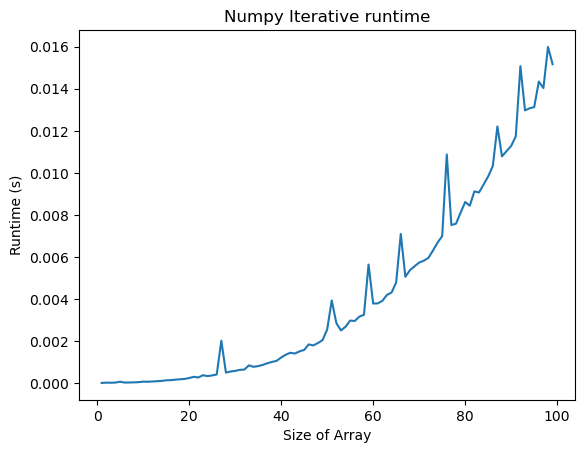

In [259]:
n_vals = np.arange(1, len(all_times[:, 0]) + 1, 1)

plt.figure()
plt.plot(n_vals, all_times[:, 0])
plt.title("Sum Iterative runtime")
plt.xlabel("Size of Array")
plt.ylabel("Runtime (s)")

# plt.figure()
# plt.plot(n_vals, all_times[:, 1])
# plt.title("Numpy Iterative runtime")
# plt.xlabel("Size of Array")
# plt.ylabel("Runtime (s)")

plt.figure()
plt.plot(n_vals, all_times[:, 2])
plt.title("Numpy Iterative runtime")
plt.xlabel("Size of Array")
plt.ylabel("Runtime (s)")

### The scaling stays the same, but the "prefactor" changes

+ The runtime of both functions appears to increase faster than linearly with the number of points, $N$. This makes sense, because finding the distance between all pairs of $N$ objects should require $\sim \mathcal{O}(N^2)$ operations.

+ But the "prefactor" (the scale of the y-axis) is much lower for the vectorized code. So vectorization offers a practical speedup, but not an intrinsic change in the complexity of the problem.

+ Generally, we should think of runtime complexity as an intrinsic mathematical property of the algorithm, while the "prefactor" is a practical consideration that depends on the implementation and hardware.

+ Under the hood, numpy is actually still looping over the elements of the array, but it is deferring this operation to C, a compiled language, rather than C. So by expression our program using higher-level mathematical objects, we gave numpy enough insight into the code to properly optimize it.

+ Generally, in vectorization, we think of the compiled, behind-the-scenes code as being executed instantaneously or in parallel (even if it's not actually in practice). Whenever you have an array operation that seems like it can be done in parallel, there's likely a way to vectorize it.

## Finding the fractal basins of the Mandelbrot set

Creation of the fractal Mandelbrot set involves iterating the following function at each lattice point:


$$
z_{t + 1} = z_{t}^2 + c
$$
where the complex number $z = x + i y$ encodes a 2D spatial position. This update rule is equivalent to the 2D update rule

$$
x_{t + 1} = x_t^2 - y_t^2 + c \\
y_{t + 1} = 2 x y 
$$

For the Mandelbrot set, we are interested in plotting, for each initial condition $z_0$, the asymptotic value $\lim_{n \rightarrow \infty} |z_n|$. For some points the set diverges, and for others it converges. The boundary between these two regions is the Mandelbrot set.


*Adapted from Nicolas Rougier & Loïc Houpert's [book](https://lhoupert.fr/test-jbook/04-code-vectorization.html#uniform-vectorization)*


For our implementation of the Mandelbrot set, we could work directly with float arrays for $x$ and $y$. However, Python conveniently provides a built-in `complex` data type, which is a pair of floats representing the real and imaginary parts of a complex number. We will use this data type to represent the complex numbers in our Mandelbrot set.

Let's start by plotting two trajectories of the Mandelbrot set that start from different initial conditions. 

Text(0, 0.5, 'Value')

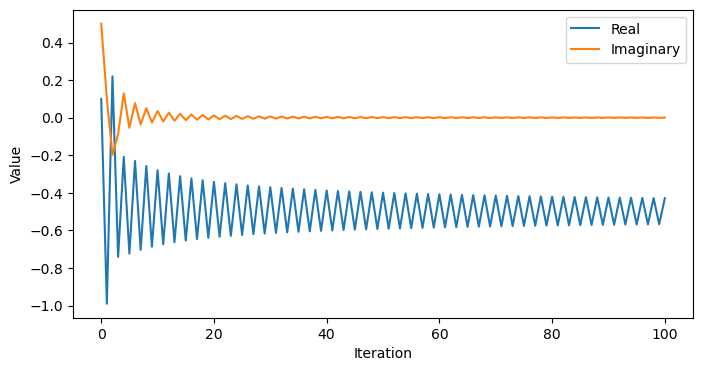

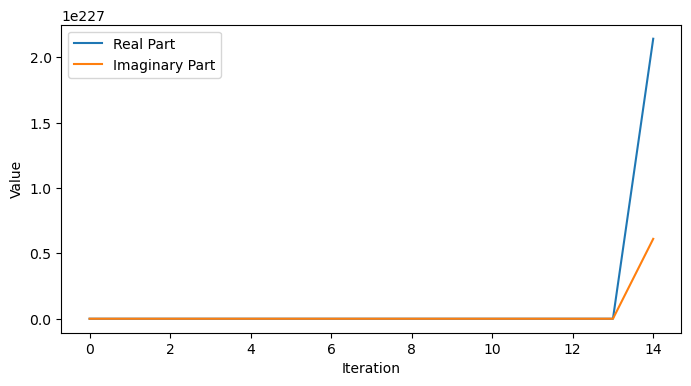

In [17]:
def mandelbrot_map(z0, c=-3/4, max_iters=100):
    """
    Compute the Mandelbrot fractal using iteration and a vectorized approach
    """
    z = [z0]
    for i in range(max_iters):
        z.append(z[-1]**2 + c)
    return np.array(z)

# A single complex number in Python, here representing an initial condition
z0 = 0.1 + 1j * 0.5 
traj = mandelbrot_map(z0)

plt.figure(figsize=(8, 4))
plt.plot(np.real(traj))
plt.plot(np.imag(traj))
plt.legend(['Real', 'Imaginary'])
plt.xlabel('Iteration')
plt.ylabel('Value')


z0 = -0.5 + 1j * 0.5
traj = mandelbrot_map(z0)

plt.figure(figsize=(8, 4))
plt.plot(np.real(traj))
plt.plot(np.imag(traj))
plt.legend(['Real Part', 'Imaginary Part'])
plt.xlabel('Iteration')
plt.ylabel('Value')

We are interested in finding the basins of attraction, which the subregions of the complex plane that converge to the same asymptotic value. We can do this by computing trajectories of the Mandelbrot set for a grid of initial conditions in the complex plane.

In our implementation, we iterate over a grid of initial conditions and then calculate the trajectory under the Mandelbrot map. If the absolute value of the trajectory exceeds a threshold, we assume that means that those initial conditions diverged. We therefore assign the initial condition to the basin of attraction corresponding to the threshold that was exceeded.

In [32]:
def mandelbrot_iterative(z, maxiter=20, horizon=2.0, c=-3/4):
    """
    An implementation of the Mandelbrot set using iterative loops
    We use the built-in complex type, although we could have also split into separate 
    iterations for the real and imaginary parts

    Args:
        z (complex): A 2D array of complex numbers to iterate
        maxiter (int): The maximum number of iterations to perform
        horizon (float): The maximum value of the magnitude of the complex number
        c (complex): The control parameter for the map

    Returns:
        z (complex): A 2D array of complex numbers, with values of 0 or 1 depending on 
            whether they diverge or not
    """
    n, m = z.shape
    
    for i in range(n):
        for j in range(m):
            for t in range(maxiter):
                if abs(z[i, j]) >= horizon:
                    z[i, j] = horizon
                else:
                    z[i, j] = z[i, j]**2 + c
    return z


# define a list of the x, y meshpoints at which we will compute the mandelbrot set
xx, yy = np.meshgrid(np.linspace(-1.5, 0.5, 600), np.linspace(-1, 1, 600))
zz = xx + 1j * yy

print(zz.shape)

# # print(zz.shape)
horizon_vals = mandelbrot_iterative(zz)



(600, 600)


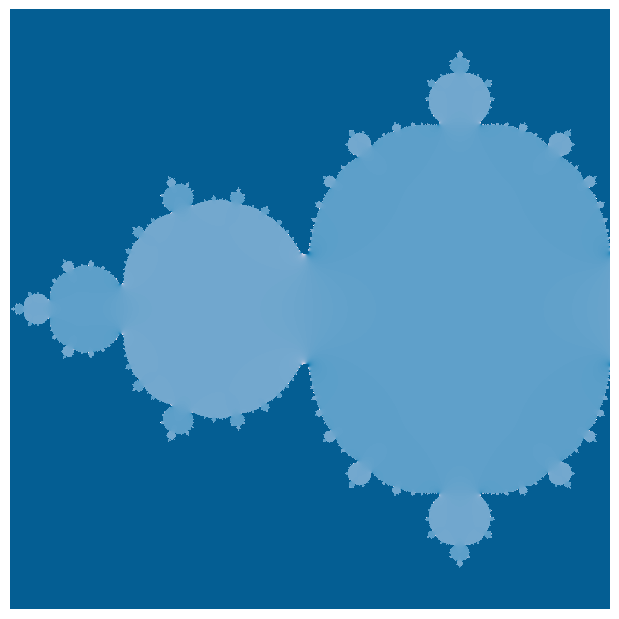

In [34]:
plt.figure(figsize=(12, 6))
plt.imshow(np.real(horizon_vals), cmap="PuBu")
plt.axis('off'); plt.tight_layout(pad=0) # remove all axes, padding, and ticks

In our vectorized implementation, we will use the same algorithm, but we will iterate the entire initial condition array all at the same time. We will use Boolean indexing to assign different values, depending on whether a given array point is diverging or not.

Text(0.5, 1.0, 'Mandelbrot Set')

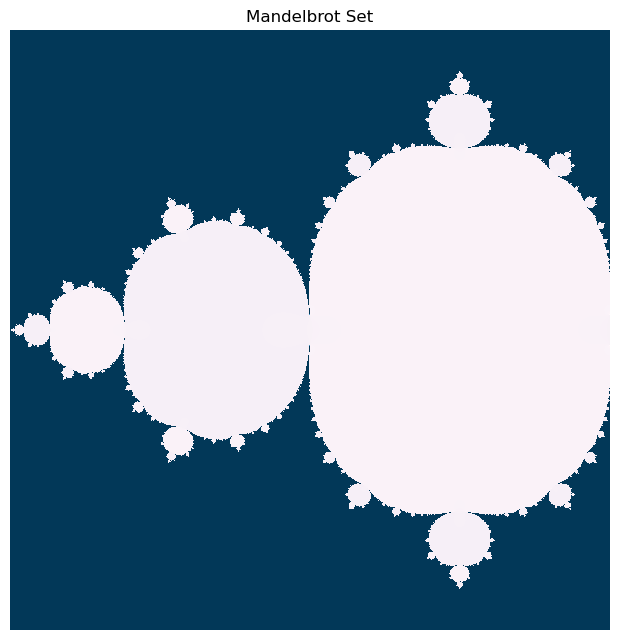

In [31]:
def mandelbrot_numpy(z, maxiter=20, horizon=5.0, c=-3/4):
    """
    A vectorized implementation of the Mandelbrot set using numpy

    Args:
        z (complex): A 2D array of complex numbers to iterate
        maxiter (int): The maximum number of iterations to perform before giving up
        horizon (float): The maximum value of the magnitude of the complex number
        c (complex): The control parameter for the map

    Returns:
        z (complex): A 2D array of complex numbers, with values of 0 or 1 depending on
            whether they diverge or not
    """
    z = z.astype(np.complex64) # cast to numpy's own complex type
    for t in range(maxiter):
        z[np.abs(z) <= horizon] = z[np.abs(z) <= horizon]**2 + c
        z[np.abs(z) > horizon] = horizon

    return z

# define the x, y meshpoints at which we will compute the mandelbrot set
xx, yy = np.meshgrid(np.linspace(-1.5, 0.5, 600), np.linspace(-1, 1, 600))
zz = xx + 1j * yy
horizon_vals = mandelbrot_numpy(zz, maxiter=200)

# plt.figure(figsize=(12, 6))
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(horizon_vals), cmap="PuBu")
plt.axis('off'); plt.tight_layout(pad=0) # remove all axes, padding, and ticks
plt.title("Mandelbrot Set")



Let's do a timing experiment, where we see how the runtime of our two implementations changes as we increase the number of iterations.

Text(0, 0.5, 'Runtime (s)')

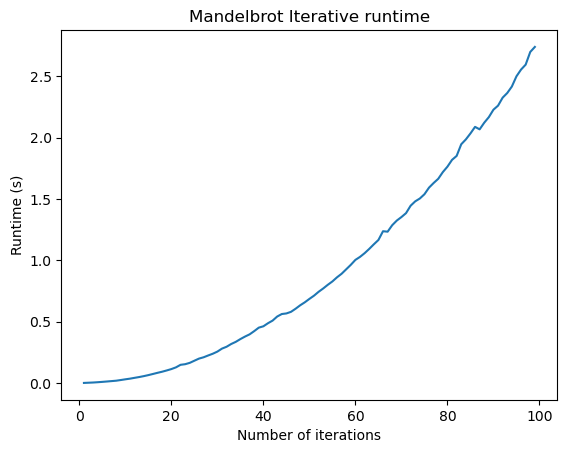

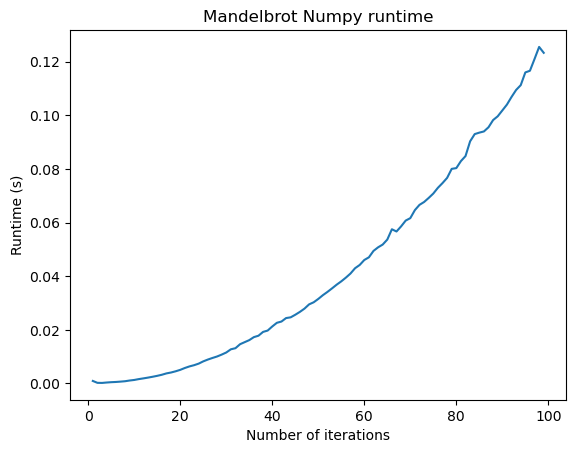

In [375]:
import timeit

n_vals = np.arange(1, 100, 1)

# define the x, y meshpoints at which we will compute the mandelbrot set
xx, yy = np.meshgrid(np.linspace(-1.5, 0.5, 30), np.linspace(-1, 1, 30))
zz = xx + 1j * yy

all_times = []
for n in n_vals:
    time1 = timeit.timeit(
        "mandelbrot_iterative(zz, maxiter=n)", globals=globals(), number=n
    )
    time2 = timeit.timeit(
        "mandelbrot_numpy(zz, maxiter=n)", globals=globals(), number=n
    )
    all_times.append([time1, time2])
all_times = np.array(all_times)

plt.figure()
plt.plot(n_vals, all_times[:, 0])
plt.title("Mandelbrot Iterative runtime")
plt.xlabel("Number of iterations")
plt.ylabel("Runtime (s)")

plt.figure()
plt.plot(n_vals, all_times[:, 1])
plt.title("Mandelbrot Numpy runtime")
plt.xlabel("Number of iterations")
plt.ylabel("Runtime (s)")

Our numpy vectorized implementation is fast enough that we can zoom in and explore the fractal structure of the Mandelbrot set.

Text(0.5, 1.0, 'Mandelbrot Set Angle (Zoomed In)')

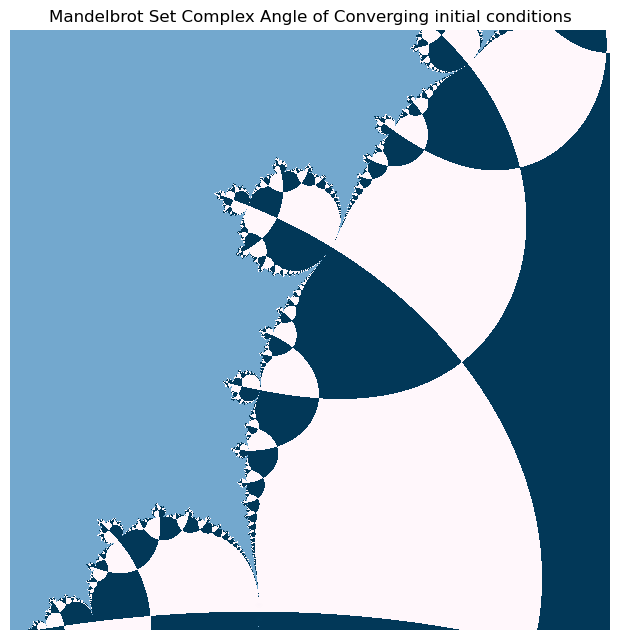

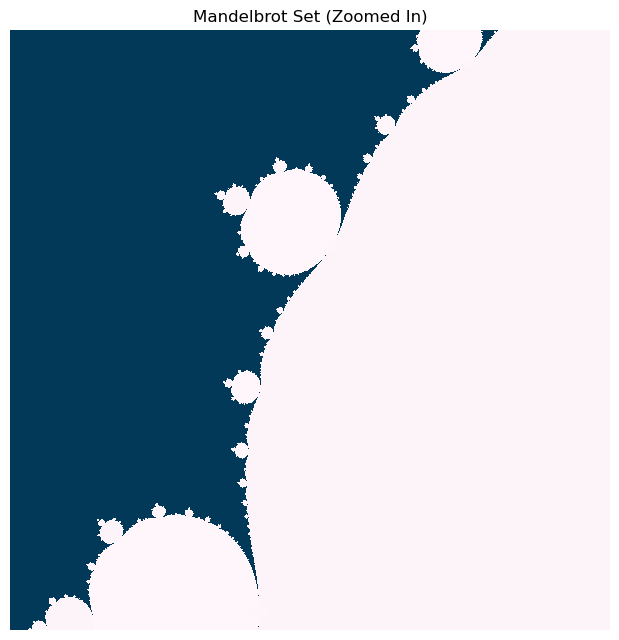

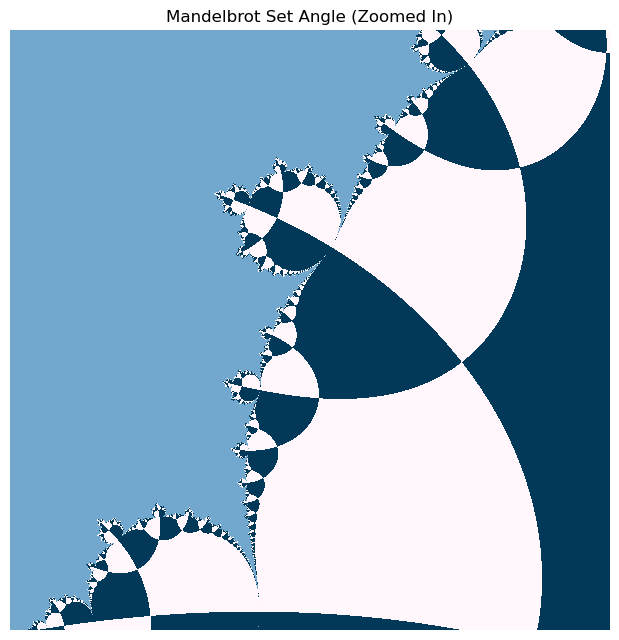

In [367]:
plt.figure(figsize=(12, 6))
plt.imshow(np.angle(horizon_vals), cmap="PuBu")
plt.axis('off'); plt.tight_layout(pad=0) # remove all axes, padding, and ticks
plt.title("Mandelbrot Set Complex Angle of Converging initial conditions")


# define the x, y meshpoints at which we will compute the mandelbrot set
xx, yy = np.meshgrid(np.linspace(-0.385, -0.355, 600), np.linspace(-0.52, -0.55, 600))
zz = xx + 1j * yy
horizon_vals = mandelbrot_numpy(zz, maxiter=10*100)
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(horizon_vals), cmap="PuBu")
plt.axis('off'); plt.tight_layout(pad=0) # remove all axes, padding, and ticks
plt.title("Mandelbrot Set (Zoomed In)")


plt.figure(figsize=(6, 6))
plt.imshow(np.angle(horizon_vals), cmap="PuBu")
plt.axis('off'); plt.tight_layout(pad=0) # remove all axes, padding, and ticks
plt.title("Mandelbrot Set Angle (Zoomed In)")

In [ ]:
from scipy.spatial.distance import pdist, cdist